In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data PreProcessing

In [2]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
# fix values in TotalCharges from data analysis notebook
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
nan_column = df.columns.get_loc("TotalCharges")

imp = SimpleImputer(missing_values=np.nan, strategy="mean")

df.iloc[:, nan_column] = imp.fit_transform(df.iloc[:, nan_column].values.reshape(-1, 1))
df.iloc[:, nan_column] = pd.Series(df.iloc[:, nan_column])
print("Null values =", df.isnull().values.any())

Null values = False


In [4]:
# drop customerID
df_dummies = df.drop(['customerID'],axis=1)

#Convert the predictor variable in a binary numeric variable
df_dummies['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df_dummies['Churn'].replace(to_replace='No',  value=0, inplace=True)

df_dummies = pd.get_dummies(df_dummies)

In [5]:
# create x and y values and convert to floats
X = df_dummies.drop(['Churn'],axis=1).astype('float32')
y = df_dummies['Churn'].astype('float32')
print(X.shape,'\n',y.shape)

(7043, 45) 
 (7043,)


## Training

In [6]:
# Scale all the variables in range 0 to 1

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

# split the data for training
X_train , X_test , y_train , y_test = train_test_split(X ,y , test_size =.3)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
# train the Gradient Boosting classifier

GBC_classifier = GradientBoostingClassifier(learning_rate=0.005, 
                                            n_estimators=2000,
                                            max_depth=2, 
                                            min_samples_split=1200, 
                                            min_samples_leaf=7, 
                                            subsample=0.85, 
                                            random_state=10, 
                                            max_features=26,
                                            warm_start=True)

In [8]:
GBC = GBC_classifier.fit(X_train, y_train)
y_pred_log = GBC.predict(X_test)

___
## Visualising the Features Affecting Churn

In [9]:
importances = GBC.feature_importances_

In [10]:
GBC_fea = pd.DataFrame(importances)
GBC_fea["Feature"] = list(X_train) 
GBC_fea.sort_values(by=0, ascending=False).head(5)

,0,Feature
36,0.273780,Contract_Month-to-month
1,0.179405,tenure
18,0.117903,OnlineSecurity_No
16,0.102365,InternetService_Fiber optic
27,0.081330,TechSupport_No


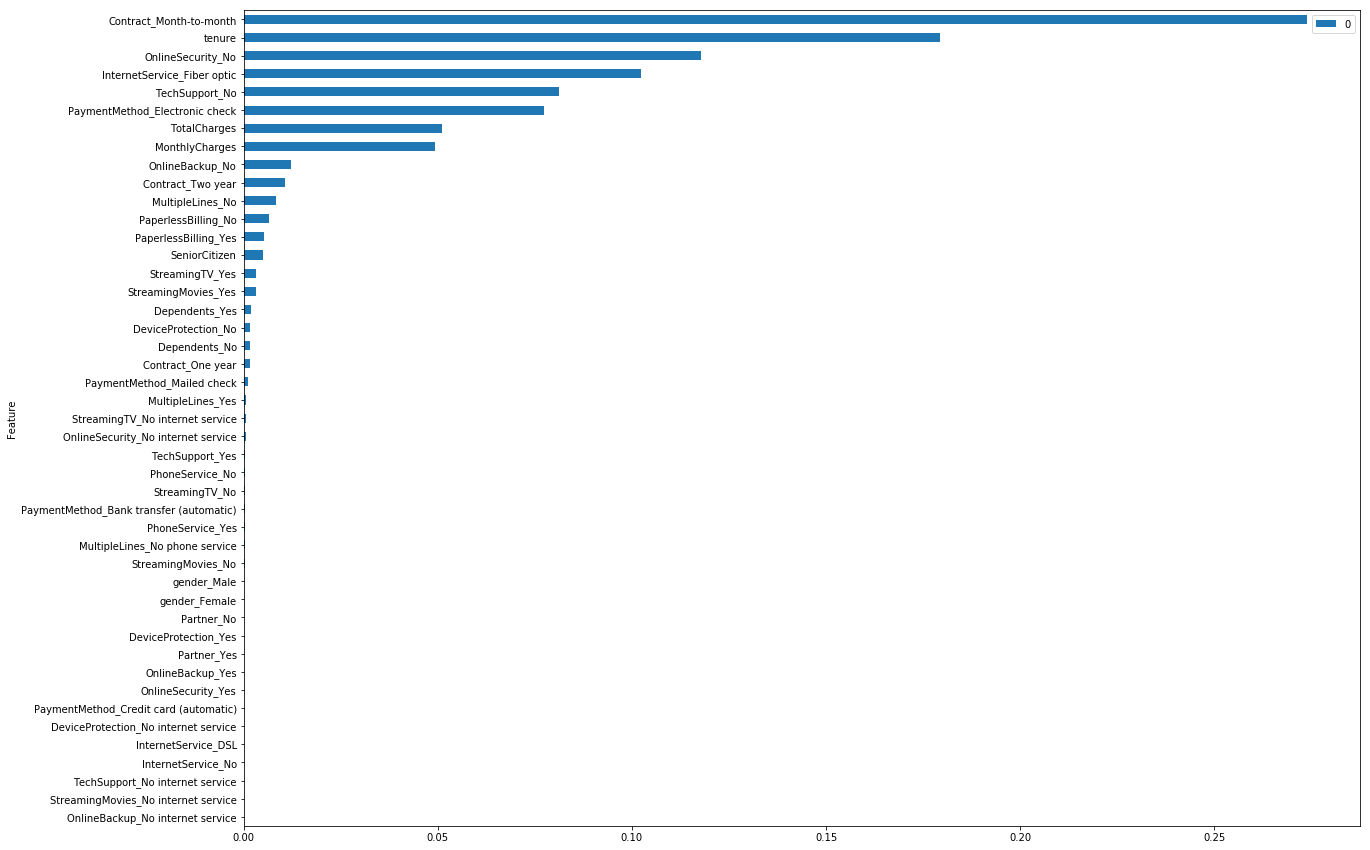

In [11]:
GBC_fea.set_index(keys='Feature').sort_values(by=0, ascending=True).plot(kind='barh', figsize=(20, 15))

The top 5 features affecting churn are:

* Customer on a Month to month contract
* The length of their tenure with the business
* No online security included in their package
* The amount they are charged per month
* No technical support included on their package

Recommendations for decreasing churn:

* Incentivise customers to sign up for annual contracts
* Increase the availability of online security and technical support on their packages. You could use a tiered system depending on the price paid.
* Lower the amount a customer is charged per month. This will directly affect revenue. Improvements in business efficiency will be required so the savings can be passed on to customers.

___
## Make Predictions on the Dataset

In [12]:
customer_id = df['customerID']
label = df_dummies['Churn']
df_dummies= df_dummies.drop(['Churn'],axis=1)

In [13]:
# copy dataset and predict churn per customerID
output_df = df_dummies.copy()
output_df['prediction'] = GBC.predict_proba(output_df)[:,1]
output_df['churn'] = label
output_df['customerID'] = customer_id

In [14]:
print('Mean probability of churn:',round(output_df[output_df['churn'] == 1]['prediction'].mean(),2))
print('Mean probability of NON-churn:',round(output_df[output_df['churn'] == 0]['prediction'].mean(),2))

Mean probability of churn: 0.33
Mean probability of NON-churn: 0.16


Use this dataframe to target customers who haven't churned but are likely to.

In [15]:
activate = output_df[output_df['churn'] == 0]
activate[['customerID','churn','prediction']].sort_values(by='prediction', ascending=False)

,customerID,churn,prediction
3305,5144-TVGLP,0,0.623320
1724,7398-SKNQZ,0,0.593451
1516,6198-RTPMF,0,0.593451
2219,1302-UHBDD,0,0.592198
5250,3338-CVVEH,0,0.591883
5227,4060-LDNLU,0,0.591883
4284,8189-XRIKE,0,0.590459
214,2504-DSHIH,0,0.583576
3981,1200-TUZHR,0,0.578024
701,9450-TRJUU,0,0.573464


There are many variables we can choose to lower churn. The best overall result would be to target the top 500 customers by offering them fixed contracts, lower costs or increase in online security and techincal services to make them stay.